In [106]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [13]:
np.random.seed(10)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Данные по раку груди, https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
Фичи:
1) ID number
2) Diagnosis (M = malignan (злокачественная)t, B = benig (доброкачественная)n)
3-32)Для каждого ядра клетки вычисляются десять вещественных признаков:

аradius - ) радиус (среднее значение расстояний от центра до точек периметра)
texture - б) текстура (стандартное отклонение значений шкалы серого)perimeter - 
в) периметрarea - 
г) площадsmoothness - ь
д) гладкость (локальное изменение длины радиусоcompactness - в)
е) компактность (периметр^2/площадь - 1concavity - ,0)
ж) вогнутость (выраженность вогнутых участков контconcave points - ура)
з) вогнутые точки (количество вогнутых участков конsymmetry - тура)
и) симfractal dimension - метрия
к) фрактальная размерность («приближение береговой 
ion" - 1)линии» - 1)oximation" - 1)

# Загружаем данные

In [46]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 
  
# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
print(breast_cancer_wisconsin_diagnostic.variables) 

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'published_in': 'Electronic imaging', 'year': 1993, 'url': 'https://www.semanticscholar.org/paper/53

In [15]:
X.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [16]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


# EDA

In [17]:
X.shape

(569, 30)

In [18]:
X.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [19]:
X.isnull().sum()

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
dtype: int64

В данных нет пропусков, все фичи уже являются числовыми

## Распределение целевой переменной

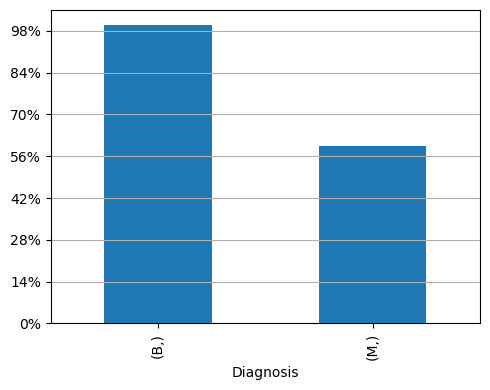

In [20]:
from matplotlib.ticker import PercentFormatter
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig = y.value_counts().plot.bar(figsize=(5, 4))
axs.yaxis.set_major_formatter(PercentFormatter(xmax=y.value_counts().max()))
axs.grid(axis='y')

В данных в полтора раза преобладает класс B - доброкачественные опухоли 

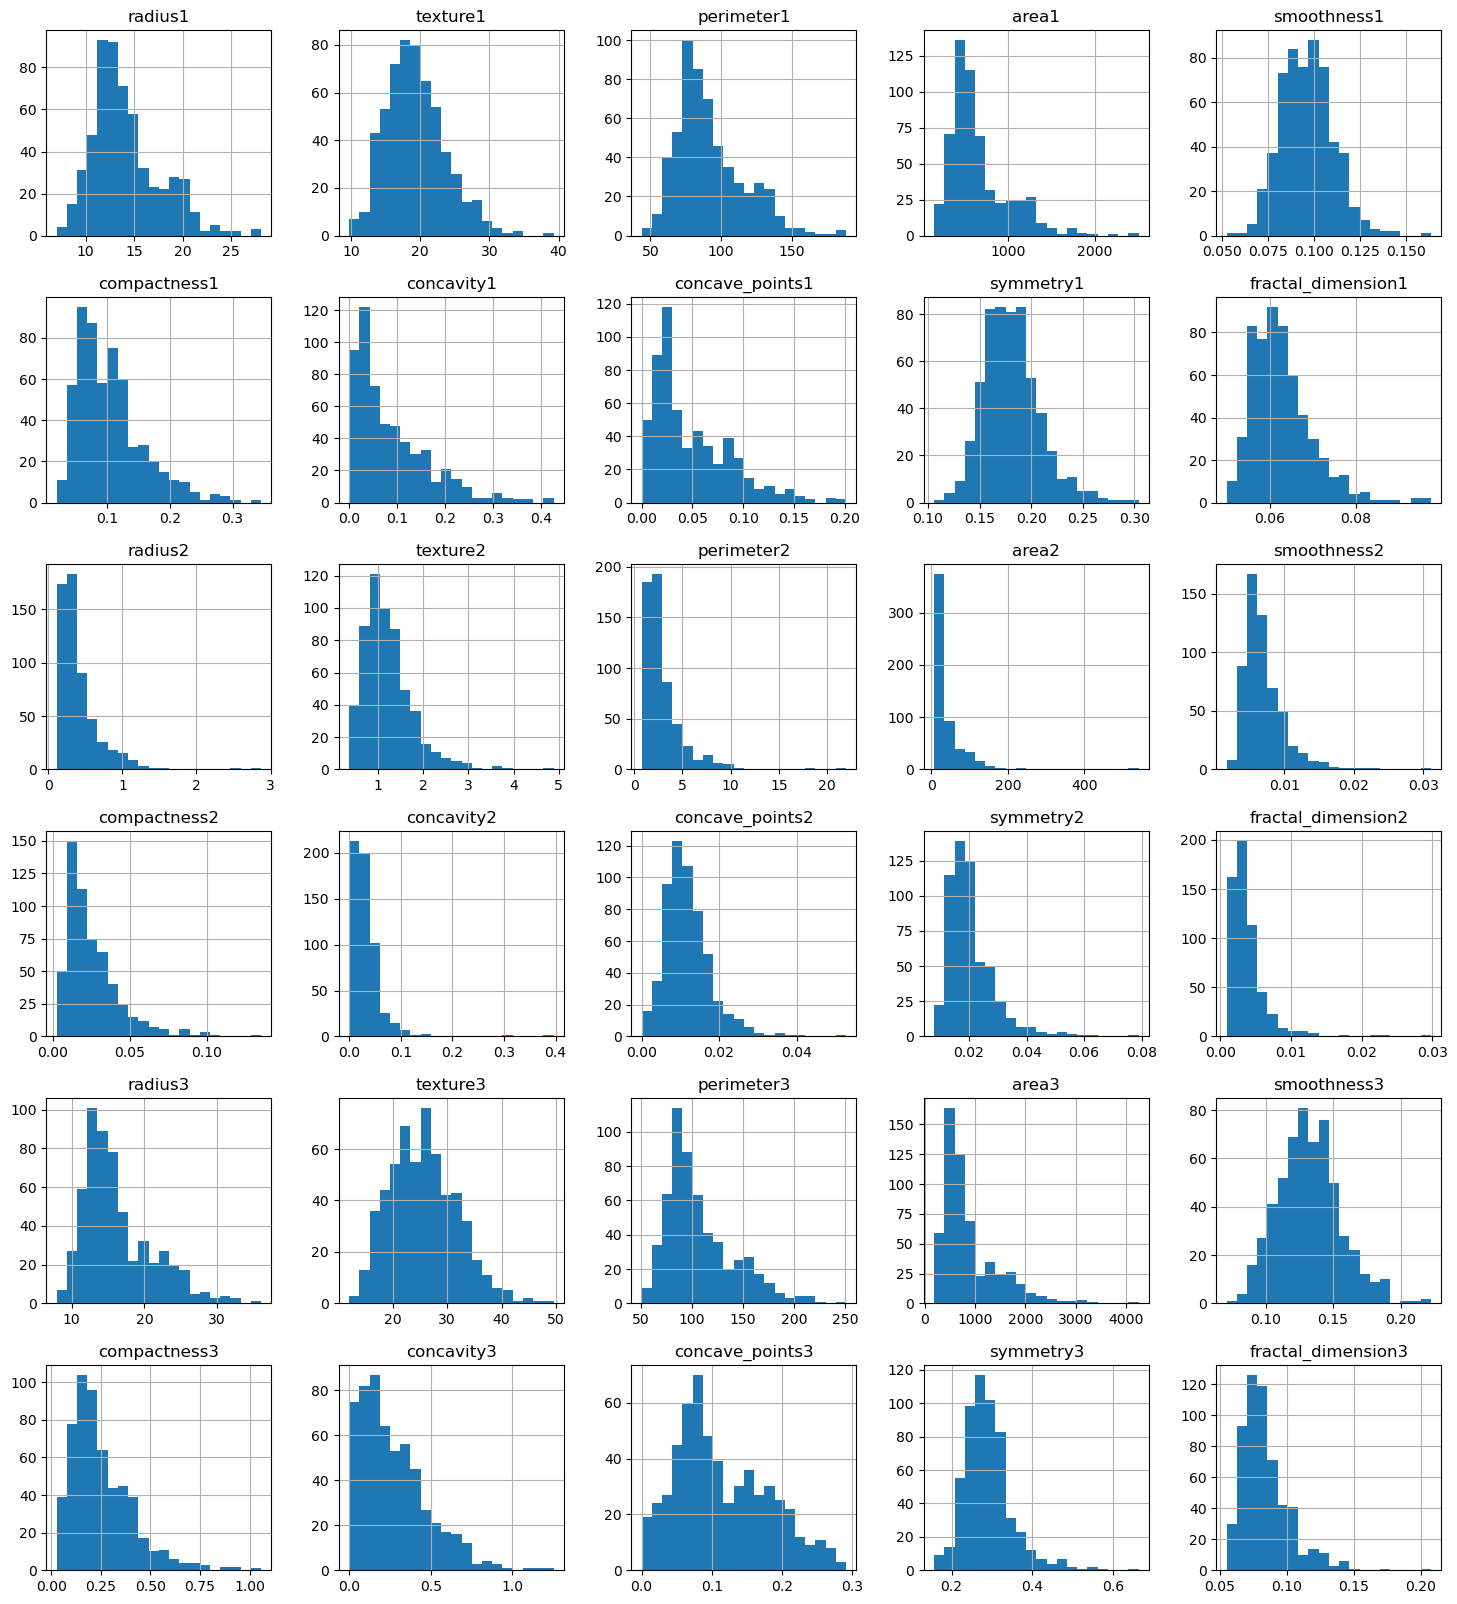

In [21]:
X.hist(figsize=(18, 20), bins=20);

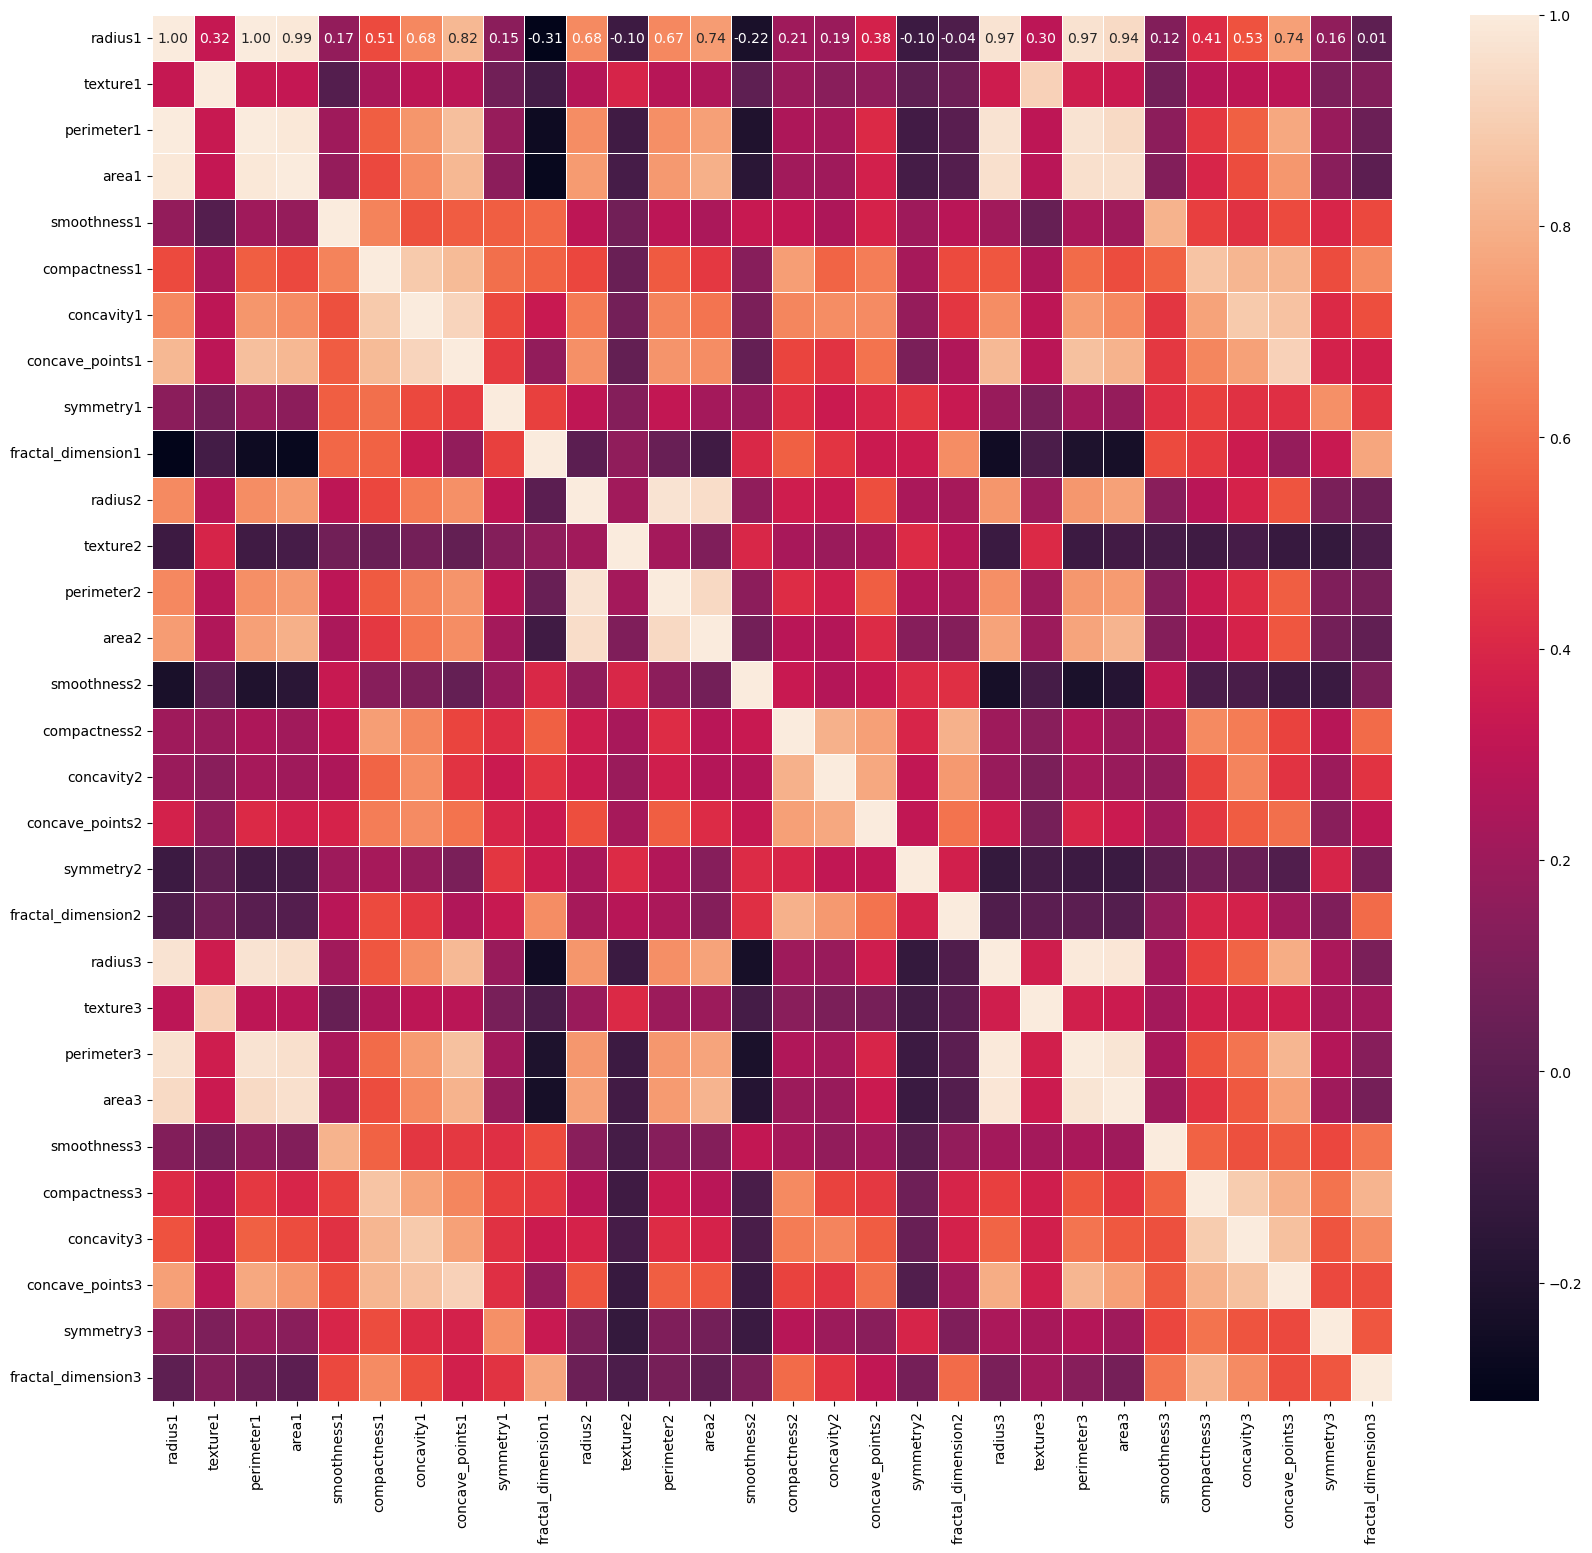

In [22]:
#correlation map
plt.figure(figsize=(20, 18))
sns.heatmap(X.corr(), annot=True, cbar=True, linewidths=.5, fmt= '.2f')
plt.show()

Видим, что фичи radius1, perimeter1, area1, radius3, perimeter3, area3 сильно коррелируют, имеет смысл оставить из них один. Также сильно скоррелированы texture1 и texture3, можно удалить одну из них. Еще скоррелированы radius2, perimeter2, area2, оставим один из них.

# Готовим даные

In [23]:
X_edt = X.drop(['perimeter1', 'area1', 'radius3', 'perimeter3', 'area3', 'texture3', 'perimeter2', 'area2'], axis=1)

In [48]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [50]:
y_edt = y.copy()
y_edt['Diagnosis'] = y_edt['Diagnosis'].map({'B':0, 'M':1})
y_edt.head()

,Diagnosis
0,1
1,1
2,1
3,1
4,1


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_edt, y_edt, test_size=0.8, random_state=123)

# Классификаторы с гиперпараметрами "из коробки"

In [78]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_hat = gbc.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9239479518471707


In [79]:
gbc.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [76]:
lgbc = LGBMClassifier(verbose=-1)
lgbc.fit(X_train, y_train)
y_hat = lgbc.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9403165986366367


In [77]:
lgbc.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

In [70]:
cbc = CatBoostClassifier(verbose=False)
cbc.fit(X_train, y_train)
y_hat = cbc.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9270766425626256


In [72]:
cbc.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'lo

In [80]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_hat = xgb.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9288067463688541


In [83]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

лучше всех себя показал LightGBM

# Настройка гиперараметров

In [107]:
param_grid = {
        'n_estimators': [50, 100, 300, 500, 1000],
        'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth': [None, 3, 5, 6, 7, 9],
        'min_samples_split':[2,4,6,8,10,20], 
        'min_samples_leaf':[1,3,5,7,9],
        'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}
gbc = GradientBoostingClassifier()
rnd_search = RandomizedSearchCV(gbc, param_grid, cv=5, scoring='roc_auc', verbose=1)
rnd_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.9663003663003662

In [108]:
rnd_search.best_params_

{'subsample': 0.95,
 'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 3,
 'learning_rate': 0.1}

In [109]:
y_hat = rnd_search.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9360586784907693


In [110]:
param_grid = {
        'n_estimators': [50, 100, 300, 500, 1000],
        'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth': [-1, 3, 5, 6, 7, 9],
        'num_leaves': [30, 50, 70, 90, 110],
        'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}
lgbc = LGBMClassifier(verbose=-1)
rnd_search = RandomizedSearchCV(lgbc, param_grid, cv=5, scoring='roc_auc', verbose=1)
rnd_search.fit(X_train, y_train)
rnd_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.9647130647130646

In [111]:
rnd_search.best_params_

{'subsample': 0.7,
 'num_leaves': 90,
 'n_estimators': 1000,
 'max_depth': -1,
 'learning_rate': 0.4}

In [112]:
y_hat = rnd_search.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9455069100553218


In [113]:
param_grid = {
        'iterations': [50, 100, 300, 500, 1000],
        'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': [None, 3, 5, 6, 7, 9],
        'l2_leaf_reg': [2,3,4,5],
        'boosting_type': ['Ordered', 'Plain'],
        'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}
cbc = CatBoostClassifier(verbose=False)
rnd_search = RandomizedSearchCV(cbc, param_grid, cv=5, scoring='roc_auc', verbose=1)
rnd_search.fit(X_train, y_train)
rnd_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.9695970695970697

In [114]:
rnd_search.best_params_

{'subsample': 0.85,
 'learning_rate': 0.01,
 'l2_leaf_reg': 4,
 'iterations': 100,
 'depth': 9,
 'boosting_type': 'Ordered'}

In [115]:
y_hat = rnd_search.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9133704908522057


In [121]:
param_grid = {
        'n_estimators': [50, 100, 300, 500, 1000],
        'learning_rate' : [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth': [0, 3, 5, 6, 7, 9],
        'gamma': [0,1,2,3,4,5,6,7,8,9,10],
        'min_child_weight':[0,1,2,3,4,5,6,7,8,9,10],
        'mmax_delta_step':[0,1,2,3,4,5,6,7,8,9,10],
        'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
}
xgb = XGBClassifier()
rnd_search = RandomizedSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', verbose=1)
rnd_search.fit(X_train, y_train)
rnd_search.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


0.9638583638583638

In [122]:
rnd_search.best_params_

{'subsample': 0.9,
 'n_estimators': 1000,
 'mmax_delta_step': 7,
 'min_child_weight': 5,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 2}

In [123]:
y_hat = rnd_search.best_estimator_.predict(X_test)
print(roc_auc_score(y_test, y_hat))

0.9250150218593953


победил LGBMClassifier